# Taller 4

Autor: Guillermo Luigui Ubaldo Nieto Angarita

Rol: Estudiante en Maestría en Analítica Estrategica de Datos

Instrucciones: 
- Vectorizar con TF-IDF, Glove, Word2Vec
- Implementar técnicas de Ngrams
- Calcular la distancia del Coseno con los 3 vectorizaciones 
- representar mediante Mapa de calor los resultados de los distancia del Coseno
- Calcular y representar el Top Modeling Mediante LDA.

## 1. Limpieza del texto

### 1.1 Cargar librerías

In [61]:
import re  # Para trabajar con expresiones regulares
import spacy  # Para procesamiento de lenguaje natural (NLP)
import unicodedata  # Para normalizar caracteres Unicode
import stanza
import nltk
import fitz  # PyMuPDF
import docx2txt
import requests
import os
import gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from gensim import corpora
from transformers import AutoTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from flair.data import Sentence
from flair.models import SequenceTagger
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from huggingface_hub import login
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_distances
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models import LdaModel

### 1.2 Descargar los tokenizadores

In [2]:
nltk.download('punkt')
stanza.download('es')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2025-09-11 22:08:21 INFO: Downloaded file to C:\Users\guill\stanza_resources\resources.json
2025-09-11 22:08:21 INFO: Downloading default packages for language: es (Spanish) ...
2025-09-11 22:08:22 INFO: File exists: C:\Users\guill\stanza_resources\es\default.zip
2025-09-11 22:08:25 INFO: Finished downloading models and saved to C:\Users\guill\stanza_resources


In [3]:
nlp_stanza = stanza.Pipeline("es")
nlp_spacy = spacy.load("es_core_news_sm")  #cargar el modelo en español
tokenizer_bert = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

2025-09-11 22:08:25 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-09-11 22:08:26 INFO: Downloaded file to C:\Users\guill\stanza_resources\resources.json
2025-09-11 22:08:27 INFO: Loading these models for language: es (Spanish):
| Processor    | Package           |
------------------------------------
| tokenize     | combined          |
| mwt          | combined          |
| pos          | combined_charlm   |
| lemma        | combined_nocharlm |
| constituency | combined_charlm   |
| depparse     | combined_charlm   |
| sentiment    | tass2020_charlm   |
| ner          | conll02           |

2025-09-11 22:08:27 INFO: Using device: cpu
2025-09-11 22:08:27 INFO: Loading: tokenize
2025-09-11 22:08:27 INFO: Loading: mwt
2025-09-11 22:08:27 INFO: Loading: pos
2025-09-11 22:08:28 INFO: Loading: lemma
2025-09-11 22:08:29 INFO: Loading: constituency
2025-09-11 22:08:30 INFO: Loading: depparse
2025-09-11 22:08:30 INFO: Loading: sentiment
2025-09-11 22:08:30 INFO: Loading: ner
2025-09-11 22:08:32 INFO: Done loading processors!


### 1.3 Descargar Stopwords en Español

In [4]:
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1.4 Cargar texto

### 1.5 Leer los Documentos Docx

In [5]:
gabriel_garcia_marquez_text = docx2txt.process("texts/Discuros Gabriel García Marquez.docx")
albert_camus_text = docx2txt.process("texts/Discurso Albert Camus.docx")
bob_dylan_text = docx2txt.process("texts/Discurso Bob Dylan.docx")
vargas_llosa_text = docx2txt.process("texts/Discurso Vargas Llosa.docx")

### 1.6 Eliminación de elementos no deseados

In [6]:
def extract_text_without_unwanted_elements(text):
    text = re.sub(r"[^a-zA-Z0-9áéíóúÁÉÍÓÚüÜñÑ\s]", "", text)
    return text

In [7]:
def extract_text_without_unwanted_elements_sentences(text):
    """
    Clean Spanish text but keep sentence delimiters (.!?¡¿) and newlines.
    """
    # Keep Spanish letters, digits, spaces, newlines, and sentence delimiters
    text = re.sub(r"[^a-zA-Z0-9áéíóúÁÉÍÓÚüÜñÑ \n\.\!\?\¡\¿]", "", text)
    
    # Optional: normalize multiple newlines into a single one
    text = re.sub(r"\n+", "\n", text)
    
    return text


### 1.6 Conversión a minúsculas

In [8]:
def convertToLowerCase(text):
    return text.lower()

### 1.7 Transformación UNICODE

In [9]:
def unicodeTransformation(text, method):
    return unicodedata.normalize(method, text)

### 1.8 Tokenización

In [10]:
def stanza_tokenization_words(text):
    doc = nlp_stanza(text)
    return [word.text for sent in doc.sentences for word in sent.words]

In [11]:
def stanza_tokenization_sentences(text):
    """
    Tokenize text into words using Stanza (Spanish).
    Returns: list of tokens per sentence (nested list).
    """
    doc = nlp_stanza(text)
    return [[word.text for word in sent.words] for sent in doc.sentences]

### 1.9 Eliminación de stop words

In [12]:
# --- Function for spaCy ---
def remove_stopwords_spacy(text):
    """
    Return Spanish text without stop words using spaCy
    """
    nlp = spacy.load("es_core_news_sm")
    doc = nlp(text)
    filtered = [token.text for token in doc if not token.is_stop]
    return " ".join(filtered)

### 1.10 Lematización

In [13]:
def lemmatize_with_stanza(text):
    """
    Lemmatize text using Stanza (Spanish pipeline).
    Returns a flat list of lemmas.
    """
    doc = nlp_stanza(text)
    return [word.lemma for sent in doc.sentences for word in sent.words]


In [14]:
def lemmatize_with_stanza_sentences(text):
    """
    Lemmatize text using Stanza.
    Splits into sentences and returns list of lists of lemmas.
    """
    doc = nlp_stanza(text)
    
    lemmatized_sentences = []
    for sent in doc.sentences:
        lemmas = [word.lemma for word in sent.words]
        lemmatized_sentences.append(lemmas)
    
    return lemmatized_sentences


### 1.11 Stemming

In [15]:
# --- Function 2: Stemming with NLTK ---
def stem_spanish(text):
    """
    Stem Spanish text (no stopword removal)
    """
    stemmer = SnowballStemmer("spanish")
    tokens = nltk.word_tokenize(text, language="spanish")
    stems = [stemmer.stem(word) for word in tokens if word.isalpha()]
    return stems

### 1.12 Identificar NERs

In [16]:
def apply_ner(text):
    sentence = Sentence(text)
    tagger.predict(sentence)
    entities = [(entity.text, entity.labels[0].value) for entity in sentence.get_spans('ner')]
    return entities

### 1.13 Procedimiento de Textos

In [17]:
def text_processing_pipeline_words(text):
    text_unicode = unicodeTransformation(text, "NFKD")

    text_cleaned = extract_text_without_unwanted_elements(text_unicode)

    text_lower_case = convertToLowerCase(text_cleaned)

    text_without_stop_words = remove_stopwords_spacy(text_lower_case)

    tokens = stanza_tokenization_words(text_without_stop_words)
    
    lammes = lemmatize_with_stanza(' '.join(tokens))
    
    return ' '.join(lammes)

In [18]:
def text_processing_pipeline_sentences(text):
    # Step 1: Unicode normalization
    text_unicode = unicodeTransformation(text, "NFKD")

    # Step 2: Clean unwanted elements
    text_cleaned = extract_text_without_unwanted_elements_sentences(text_unicode)

    # Step 3: Lowercase
    text_lower_case = convertToLowerCase(text_cleaned)

    # Step 4: Remove stopwords
    text_without_stop_words = remove_stopwords_spacy(text_lower_case)

    # Step 5: Lemmatization with Stanza (handles sentence + word tokenization itself)
    lemmatized_sentences = lemmatize_with_stanza_sentences(text_without_stop_words)

    return lemmatized_sentences

### 1.14 Ejecutar Limpieza

In [19]:
gabriel_garcia_marquez_lammes = text_processing_pipeline_words(gabriel_garcia_marquez_text)

In [20]:
albert_camus_lammes = text_processing_pipeline_words(albert_camus_text)

In [21]:
bob_dylan_lammes = text_processing_pipeline_words(bob_dylan_text)

In [22]:
vargas_llosa_lammes = text_processing_pipeline_words(vargas_llosa_text)

In [23]:
gabriel_garcia_marquez_sentences = text_processing_pipeline_sentences(albert_camus_text)

In [24]:
albert_camus_sentences = text_processing_pipeline_sentences(gabriel_garcia_marquez_text)

In [25]:
bob_dylan_sentences = text_processing_pipeline_sentences(bob_dylan_text)

In [26]:
vargas_llosa_sentences = text_processing_pipeline_sentences(vargas_llosa_text)

## 2. Vectorización

### 2.1 Vectorización con TF-IDF

In [27]:
# --- Step 1: Combine documents ---
docs = [
    gabriel_garcia_marquez_lammes,
    albert_camus_lammes,
    bob_dylan_lammes,
    vargas_llosa_lammes
]

In [28]:
names = ["gabriel_garcia_marquez", "albert_camus", "bob_dylan", "vargas_llosa"]

In [29]:
# --- Step 2: Fit TF-IDF on all docs ---
# TF-IDF Vectorizer with n-grams (unigrams + bigrams)
vectorizer = TfidfVectorizer(stop_words=None, ngram_range=(1, 2))  
X = vectorizer.fit_transform(docs)  # shape = (4, n_features)

In [30]:
# --- Step 3: Save each document vector separately ---
doc_vectors_tf_idf = {}
for i, name in enumerate(names):
    doc_vectors_tf_idf[name] = X[i]  # sparse vector

### 2.2 Vectorización con GloVe

In [31]:
url = "http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz"
local_path = "glove-sbwc.i25.vec.gz"

if not os.path.exists(local_path) or os.path.getsize(local_path) == 0:
    print(f"Downloading {local_path} ...")
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024  # 1 KB
    
    with open(local_path, "wb") as file, tqdm(
        total=total_size, unit="iB", unit_scale=True
    ) as bar:
        for chunk in response.iter_content(block_size):
            file.write(chunk)
            bar.update(len(chunk))
    
    print("✅ Download complete.")
else:
    print(f"✅ File already exists ({os.path.getsize(local_path)} bytes). No download needed.")

✅ File already exists (949886421 bytes). No download needed.


In [32]:
# Step 1: Load embeddings (works with gzipped file)
def load_embeddings(file_path, vocab=None):
    embeddings = {}
    dim = None
    with gzip.open(file_path, "rt", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if dim is None:  # detect dimension automatically
                dim = len(parts) - 1
            if vocab is None or word in vocab:
                try:
                    vector = np.array(list(map(float, parts[1:])))
                    embeddings[word] = vector
                except ValueError:
                    continue
    return embeddings, dim

In [33]:
# Step 2: Build n-grams
def make_ngrams(docs, n=2, min_count=2, threshold=5):
    if n == 1:
        return docs
    phrases = Phrases(docs, min_count=min_count, threshold=threshold)
    ngram = Phraser(phrases)
    return [ngram[doc] for doc in docs]

In [34]:
# Step 3: Vectorize text
def vectorize_text(tokens, embeddings, dim):
    vecs = []
    for token in tokens:
        if token in embeddings:
            vecs.append(embeddings[token])
        elif "_" in token:  # if it's a bigram/trigram, average components
            parts = token.split("_")
            part_vecs = [embeddings[p] for p in parts if p in embeddings]
            if part_vecs:
                vecs.append(np.mean(part_vecs, axis=0))
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

In [35]:
docs = [
    gabriel_garcia_marquez_lammes.split(),
    albert_camus_lammes.split(),
    bob_dylan_lammes.split(),
    vargas_llosa_lammes.split()
]


In [36]:
# Build bigrams (set n=1 for unigrams, n=2 for bigrams, n=3 for trigrams)
docs_ngrams = make_ngrams(docs, n=2)

In [37]:
# Collect vocab
all_vocab = set([w for doc in docs_ngrams for w in doc])

In [38]:
# Load only relevant embeddings
local_path = "glove-sbwc.i25.vec.gz"
embeddings, dim = load_embeddings(local_path, all_vocab)

In [39]:
# Get vectors for each document
gabriel_vec_glove = vectorize_text(docs_ngrams[0], embeddings, dim)
camus_vec_glove   = vectorize_text(docs_ngrams[1], embeddings, dim)
dylan_vec_glove   = vectorize_text(docs_ngrams[2], embeddings, dim)
llosa_vec_glove   = vectorize_text(docs_ngrams[3], embeddings, dim)

In [40]:
# === Step 7: Inspect results ===
print("Gabriel García Márquez:", gabriel_vec_glove[:5])
print("Albert Camus:", camus_vec_glove[:5])
print("Bob Dylan:", dylan_vec_glove[:5])
print("Vargas Llosa:", llosa_vec_glove[:5])

Gabriel García Márquez: [-0.04001103  0.06958032 -0.01171007 -0.00868808 -0.00860212]
Albert Camus: [-0.09984587  0.12499387 -0.0056038   0.01600937 -0.02292111]
Bob Dylan: [-0.0386673   0.10300651  0.01630648  0.04457312  0.10302979]
Vargas Llosa: [-0.06080821  0.10940978 -0.02779223 -0.00382199  0.01150396]


### 2.3 Vectorización con Word2Vec

In [41]:
def vectorize_doc_word2vec(sentences, ngram=2, word2vec_model=None, size=100, window=5, min_count=2, sg=1):
    """
    Vectorizes a Spanish document (cleaned & lemmatized, in sentences) using Word2Vec with configurable n-grams.

    Args:
        sentences (list[list[str]]): List of sentences, each as a list of tokens.
        ngram (int): 1=unigrams, 2=bigrams, 3=trigrams, etc.
        word2vec_model (gensim.Word2Vec, optional): Pretrained Word2Vec model. If None, trains a new one.
        size (int): Dimensionality of the Word2Vec vectors.
        window (int): Context window size.
        min_count (int): Minimum frequency count for training Word2Vec.
        sg (int): 1 for skip-gram, 0 for CBOW.

    Returns:
        np.ndarray: Vector representation of the document (averaged word embeddings).
    """

    # Apply n-grams if needed
    sentences_ngrams = sentences
    if ngram > 1:
        for _ in range(1, ngram):
            phrases = Phrases(sentences_ngrams, min_count=min_count, threshold=5)
            phraser = Phraser(phrases)
            sentences_ngrams = [phraser[sent] for sent in sentences_ngrams]

    # Train Word2Vec if no pretrained model provided
    if word2vec_model is None:
        model = Word2Vec(sentences=sentences_ngrams, vector_size=size, window=window, min_count=min_count, sg=sg)
    else:
        model = word2vec_model

    # Collect vectors
    vectors = []
    for sent in sentences_ngrams:
        for w in sent:
            if w in model.wv:
                vectors.append(model.wv[w])

    # Return average vector
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(size)


In [42]:
gabriel_vec_word2vec = vectorize_doc_word2vec(gabriel_garcia_marquez_sentences)
camus_vec_word2vec   = vectorize_doc_word2vec(albert_camus_sentences)
dylan_vec_word2vec   = vectorize_doc_word2vec(bob_dylan_sentences)
llosa_vec_word2vec   = vectorize_doc_word2vec(vargas_llosa_sentences)

In [43]:
print("Norms:")
print(np.linalg.norm(gabriel_vec_word2vec))
print(np.linalg.norm(camus_vec_word2vec))
print (np.linalg.norm(dylan_vec_word2vec))
print (np.linalg.norm(llosa_vec_word2vec ))


Norms:
0.014361786
0.013135534
0.014642931
0.07455462


## 3. Calcular la distancia del coseno utilizando las tres técnicas de vectorización

In [46]:
names = ["gabriel_garcia_marquez", "albert_camus", "bob_dylan", "vargas_llosa"]

# Create a matrix with all document vectors (sparse matrix is fine)

X_all = scipy.sparse.vstack([doc_vectors_tf_idf[name] for name in names])

# Compute pairwise cosine distances
dist_matrix = cosine_distances(X_all)  # distance = 1 - cosine_similarity

# Convert to a DataFrame for easy reading
tf_idf_dist_df = pd.DataFrame(dist_matrix, index=names, columns=names)

print("Cosine Distance Matrix:\n")
print(tf_idf_dist_df)

Cosine Distance Matrix:

                        gabriel_garcia_marquez  albert_camus  bob_dylan  \
gabriel_garcia_marquez                0.000000      0.906189   0.912165   
albert_camus                          0.906189      0.000000   0.921295   
bob_dylan                             0.912165      0.921295   0.000000   
vargas_llosa                          0.816081      0.772624   0.866493   

                        vargas_llosa  
gabriel_garcia_marquez      0.816081  
albert_camus                0.772624  
bob_dylan                   0.866493  
vargas_llosa                0.000000  


In [47]:


# Stack GloVe vectors into a matrix (shape: 4 x vector_size)
glove_matrix = np.vstack([
    gabriel_vec_glove,
    camus_vec_glove,
    dylan_vec_glove,
    llosa_vec_glove
])

# Compute pairwise cosine distances
glove_dist_matrix = cosine_distances(glove_matrix)

# Convert to DataFrame for easy inspection
glove_dist_df = pd.DataFrame(glove_dist_matrix, index=names, columns=names)

print("Cosine Distance Matrix (GloVe document vectors):\n")
print(glove_dist_df)

Cosine Distance Matrix (GloVe document vectors):

                        gabriel_garcia_marquez  albert_camus  bob_dylan  \
gabriel_garcia_marquez                0.000000      0.020096   0.043974   
albert_camus                          0.020096      0.000000   0.041064   
bob_dylan                             0.043974      0.041064   0.000000   
vargas_llosa                          0.015602      0.013744   0.034654   

                        vargas_llosa  
gabriel_garcia_marquez      0.015602  
albert_camus                0.013744  
bob_dylan                   0.034654  
vargas_llosa                0.000000  


In [48]:
# Stack Word2Vec vectors into a matrix (shape: 4 x vector_size)
word2vec_matrix = np.vstack([
    gabriel_vec_word2vec,
    camus_vec_word2vec,
    dylan_vec_word2vec,
    llosa_vec_word2vec
])

# Compute pairwise cosine distances
word2vec_dist_matrix = cosine_distances(word2vec_matrix)

# Convert to DataFrame for readability
word2vec_dist_df = pd.DataFrame(word2vec_dist_matrix, index=names, columns=names)

print("Cosine Distance Matrix (Word2Vec document vectors):\n")
print(word2vec_dist_df)

Cosine Distance Matrix (Word2Vec document vectors):

                        gabriel_garcia_marquez  albert_camus  bob_dylan  \
gabriel_garcia_marquez                0.000000      0.049293   0.084500   
albert_camus                          0.049293      0.000000   0.077522   
bob_dylan                             0.084500      0.077522   0.000000   
vargas_llosa                          0.308195      0.328795   0.450840   

                        vargas_llosa  
gabriel_garcia_marquez      0.308195  
albert_camus                0.328795  
bob_dylan                   0.450840  
vargas_llosa                0.000000  


## 4 Visualizar los resultados de la distancia del coseno mediante un mapa de calor.

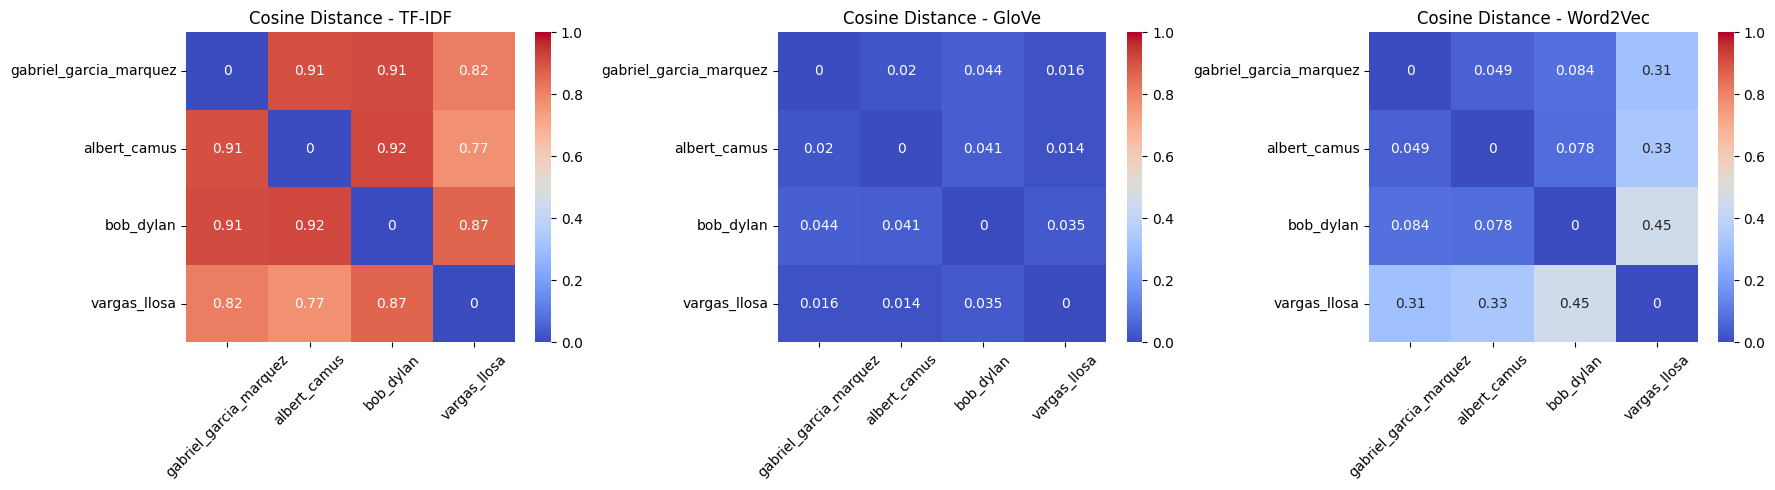

In [49]:
# Assuming you have the distance DataFrames:
# tfidf_dist_df, glove_dist_df, word2vec_dist_df
distance_matrices = {
    "TF-IDF": tf_idf_dist_df,
    "GloVe": glove_dist_df,
    "Word2Vec": word2vec_dist_df
}

# Set figure size
plt.figure(figsize=(18, 5))

for i, (name, dist_df) in enumerate(distance_matrices.items(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(dist_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    plt.title(f"Cosine Distance - {name}")
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 5. Realizar el cálculo y la representación del Topic Modeling utilizando LDA.

In [51]:
docs = [
    gabriel_garcia_marquez_lammes,
    albert_camus_lammes,
    bob_dylan_lammes,
    vargas_llosa_lammes
]


In [ ]:
tokenized_docs = [doc.split() for doc in docs]
print(tokenized_docs[0][:20])  # show first 20 tokens of García Márquez

['discurso', 'aceptación', 'premio', 'nobel', 'soledad', 'america', 'latino', '1982', 'escuchar', 'parrafo', 'antonio', 'pigafetta', 'navegante', 'florentino', 'acompano', 'magallan', 'viaje', 'mundo', 'escribio', 'paso']


In [63]:
dictionary = corpora.Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

In [ ]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,    # try 2, 3, 4... depends on your goal
    passes=20,
    random_state=42
)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.006*"él" + 0.006*"ano" + 0.005*"hombre" + 0.005*"mundo" + 0.004*"vida" + 0.004*"yo" + 0.004*"vivir" + 0.004*"tiempo" + 0.003*"mil" + 0.003*"cuyo"
Topic 1: 0.009*"él" + 0.008*"vida" + 0.007*"yo" + 0.006*"literatura" + 0.006*"historia" + 0.006*"mundo" + 0.005*"vivir" + 0.005*"escribir" + 0.005*"ano" + 0.004*"tiempo"


In [62]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.060589  0.0       1        1  64.973273
0     -0.060589  0.0       2        1  35.026727, topic_info=           Term       Freq      Total Category  logprob  loglift
342      hombre  10.000000  10.000000  Default  30.0000  30.0000
419  literatura  20.000000  20.000000  Default  29.0000  29.0000
578      poesia   4.000000   4.000000  Default  28.0000  28.0000
775        arte   5.000000   5.000000  Default  27.0000  27.0000
461         mil   7.000000   7.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
340    historia   4.826363  23.623786   Topic2  -5.8332  -0.5391
404      latino   3.691265   9.719905   Topic2  -6.1014   0.0809
598      querer   3.691800  11.138433   Topic2  -6.1012  -0.0552
518        obra   3.125886   6.314079   Topic2  -6.2676   0.3460
604     recibir   3.125518   6.314171   Topic2  -6.2677   0.3459

[151 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9         2  0.853910        20
31        2  0.853918   admitir
1274      1  0.863196  alcanzar
52        1  0.526876   americo
52        2  0.526876   americo
...     ...       ...       ...
1083      2  0.131754    volver
748       1  0.747239        yo
748       2  0.237758        yo
750       1  0.750027        él
750       2  0.258630        él

[160 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])